# Projet RCP 209 : prédiction de rendement de stock

## Import library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Accuracy function

In [6]:
def CFM_metrics(y_true, y_pred):
    """
    Return the metrics used for the CFM Data Challenge 2019.

    This metrics is simply the accuracy of the prediction of positive returns
    (see below for details), but based on true *returns* (y_true) and
    probabilities (of returns being positive).

    Args
        y_true: Pandas Dataframe
            target returns. Positive returns will give True, and negative ones False.

        y_pred: Pandas Dataframe
            predicted probability of positive returns.

    """
    return ((y_true.values > 0) == (y_pred.values > 0.5)).mean()

# Get data

In [7]:
data_test = pd.read_csv("data_stock\\test_input.csv", sep=',')
data_train = pd.read_csv("data_stock\\training_input.csv", sep=',')
output_train = pd.read_csv("data_stock\\training_output.csv", sep=',')

# Premiere analyse

In [8]:
data_train.shape, data_test.shape, output_train.shape

((745327, 74), (319769, 74), (745327, 2))

In [9]:
data_train[["eqt_code","date"]].nunique()

eqt_code     680
date        1511
dtype: int64

In [15]:
nb_donnee = data_train.iloc[:,3:].size
nb_nan = data_train.iloc[:,3:].isna().sum().sum()
print("nb de données : ", nb_donnee, " nb données manquantes : ", nb_nan, "pourcentage données manquentes : ",round(nb_nan/nb_donnee * 100,4),"%")

nb de données :  52918217  nb données manquantes :  347646 pourcentage données manquentes :  0.6569 %


## Interpolation des valeurs Nan

In [16]:
#we linearly interpolate the NaN for the volatility and extrapolate to 0 
data_train.iloc[:,3:57] = data_train.iloc[:,3:].interpolate(axis=1)
data_test.iloc[:,3:57]  = data_test.iloc[:,3:].interpolate(axis=1)
#we use a flat extrapolation
data_train.fillna(0,inplace=True)
data_test.fillna(0,inplace=True)

In [17]:
#drop not necessary data
data_train_clean = data_train.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
data_test_clean = data_test.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
y_train = output_train["end_of_day_return"].values

# Statitistique

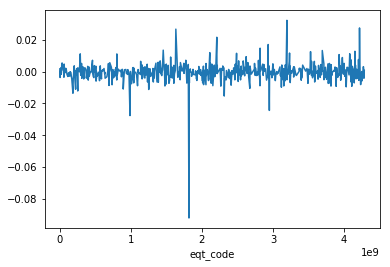

In [65]:
equity_mean = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).mean().mean(axis=1)
equity_median = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).median().median(axis=1)
equity_std = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).std().std(axis=1)
equity_hurtosis = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).apply(pd.DataFrame.)
equity_mean.plot()

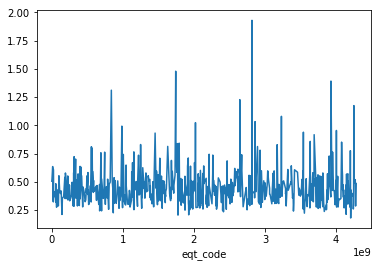

In [71]:
equity_std.plot()

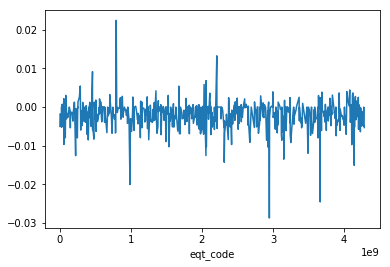

In [62]:
equity_median.plot()

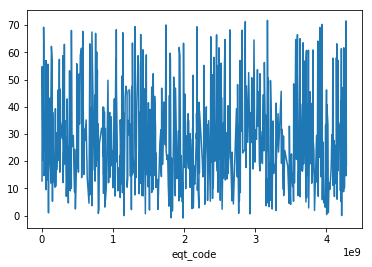

In [68]:
equity_hurtosis.T.apply(pd.DataFrame.kurtosis).plot()

In [81]:
stat = pd.DataFrame()
stat["equity mean"] = equity_mean.describe()
stat["equity median"] = equity_median.describe()
stat["equity std"] = equity_std.describe()
stat["equity kurtosis"] = equity_hurtosis.T.apply(pd.DataFrame.kurtosis).describe()
stat

,equity mean,equity median,equity std,equity kurtosis
count,680.000000,680.000000,680.000000,680.000000
mean,-0.000536,-0.002059,0.449859,27.885478
std,0.005871,0.003439,0.164241,17.648373
min,-0.091875,-0.028685,0.180033,-0.881237
25%,-0.002640,-0.003468,0.351263,14.385478
50%,-0.000398,-0.001725,0.422859,24.032289
75%,0.001794,0.000000,0.508102,38.139064
max,0.032099,0.022428,1.930473,71.750920


# Intraday equity return

In [108]:
intraday_mean = data_train.drop(["eqt_code","ID"],axis=1).groupby(["date"]).mean().mean(axis=0)
intraday = pd.DataFrame(intraday_mean)


# Linear regression

In [82]:
def trainData(model,train_set=data_train_clean,test_set=data_test_clean,output=y_train):
    print("we train")
    model.fit(train_set,output)
    print("training done, we start the prediction")
    y_pred = model.predict(train_set)
    print('Train error =', round(CFM_metrics(pd.DataFrame(data=output), pd.DataFrame(data=y_pred)), 4), '%')
    print("we return the test prediction")
    return model.predict(test_set)

def sendPredictionToCfmFormat(prediction, test = data_test, fileName = 'predictions'):
    output = pd.DataFrame()
    output["ID"] = test["ID"]
    output["end_of_day_return"] = prediction
    output.to_csv(fileName+'.csv', sep=',', index=False)
    print("prediction send to"+fileName+'.csv')
    
def compare(y1,y2):
    delta = y1 * y2
    return CFM_metrics(pd.DataFrame(y1), pd.DataFrame(y2)), np.sum(delta >=0)/len(y1)*100

In [83]:
regrLinWeighted = LinearRegression()
y_pred_linearReg = trainData(regrLinWeighted)

we train
training done, we start the prediction
Train error = 0.5029 %
we return the test prediction


In [19]:
sendPredictionToCfmFormat(y_pred_linearReg,fileName='predictionLinReg')

prediction send topredictionLinReg.csv


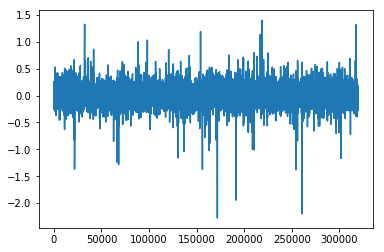

In [20]:
plt.plot(y_pred_linearReg)

## Regression with regularization : Lasso

In [21]:
lasso = Lasso(alpha=.5)
y_pred_linearRegLasso = trainData(lasso)

we train
training done, we start the prediction
Train error = 0.5029 %
we return the test prediction


In [22]:
sendPredictionToCfmFormat(y_pred_linearRegLasso,fileName='predictionLinLasso')

prediction send topredictionLinLasso.csv


In [23]:
compare(y_pred_linearRegLasso, y_pred_linearReg)

(0.0002220352817189909, 50.26941323267734)

## Regression with regularisation : Ridge

In [24]:
ridge = Ridge(alpha=2.0)
y_pred_linearRegRidge = trainData(ridge)

we train
training done, we start the prediction
Train error = 0.5029 %
we return the test prediction


In [25]:
sendPredictionToCfmFormat(y_pred_linearRegRidge,fileName='predictionLinRidge')

prediction send topredictionLinRidge.csv


In [26]:
compare(y_pred_linearRegRidge, y_pred_linearReg)

(0.4975341574699236, 99.99937454850219)

# Logistic regression

In [27]:
output_logistic= pd.DataFrame()
output_logistic["ID"] = output_train["ID"]
output_logistic["end_of_day_return"] = output_train["end_of_day_return"].apply(lambda row : 1 if row > 0 else -1)

In [28]:
logistic = LogisticRegression()
y_pred_logistic = trainData(logistic,output=output_logistic["end_of_day_return"].values)

we train
training done, we start the prediction
Train error = 0.5217 %
we return the test prediction


In [66]:
sendPredictionToCfmFormat(y_pred_logistic,fileName='predictionLogistic')

prediction send topredictionLogistic.csv


In [67]:
compare(y_pred_logistic, y_pred_linearReg)

(0.5631721649065419, 89.06304238372074)

# SVM

## Linear

In [29]:
svc = LinearSVC(tol=1.e-5,verbose=1)
y_pred_svc = trainData(svc,output=output_logistic["end_of_day_return"].values)

we train
[LibLinear]training done, we start the prediction
Train error = 0.5222 %
we return the test prediction


C:\Users\jerpetit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [31]:
sendPredictionToCfmFormat(y_pred_svc,fileName='predictionLogisticCV')

prediction send topredictionLogisticCV.csv


In [32]:
compare(y_pred_logistic, y_pred_svc)

(0.9399034928338894, 93.99034928338894)

## Kernel

In [ ]:
svcGaussian = SVC(kernel='sigmoid', tol=1e-5, verbose=1)
y_pred_gaussian = trainData(svcGaussian,output=output_logistic["end_of_day_return"].values)

we train
